В этом задании вам нужно построить классификатор, определяющий, является ли слово фамилией. Для оценки качества используется площадь под ROC-кривой (AUC), так как классы сильно несбалансированны.

Колонки

`Word` - слово, которое требуется классифицировать

`Label` - метка правильного класса

`Id` - номер слова в файле test.csv

`Prediction` - предсказание, является ли это слово фамилией



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submission.csv")

In [3]:
train.head()

,Word,Label
0,Аалтонен,1
1,Аар,0
2,Аарон,0
3,ААРОН,0
4,Аарона,0


In [4]:
test.head()

,Word
0,Аалто
1,ААР
2,Аара
3,Ааре
4,Аарон


In [5]:
train.Label.value_counts()/len(train)

0    0.895097
1    0.104903
Name: Label, dtype: float64

In [6]:
train[train.Label==1].head(20)

,Word,Label
0,Аалтонен,1
5,Аарона,1
9,Абабков,1
18,Абакумов,1
19,Абалкина,1
20,Абатуровым,1
21,Абашев,1
22,Абашидзе,1
23,Абашкина,1
24,Аббас,1


In [7]:
train[train.Label==0].head(20)

,Word,Label
1,Аар,0
2,Аарон,0
3,ААРОН,0
4,Аарона,0
6,Аароне,0
7,Ааронов,0
8,Аахена,0
10,абажур,0
11,абажуром,0
12,абажуры,0


Первый признак - первая буква заглавная

In [8]:
train['first_upper'] = train.Word.apply(lambda x: x[0].isupper())

In [9]:
train[train.Label==1].first_upper.value_counts()/len(train[train.Label==1])

True     0.880993
False    0.119007
Name: first_upper, dtype: float64

In [10]:
train[train.Label==0].first_upper.value_counts()/len(train[train.Label==0])

False    0.599912
True     0.400088
Name: first_upper, dtype: float64

Длина слова? 

In [11]:
train["length"] = train.Word.apply(lambda x: len(x))

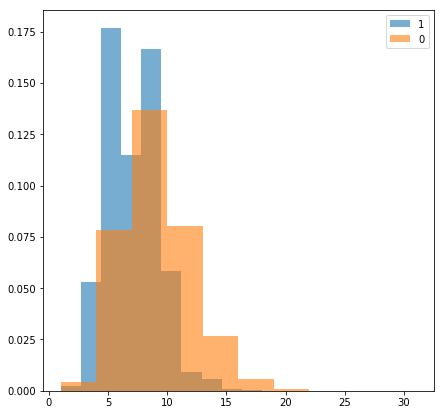

In [12]:
plt.figure(figsize=(7, 7))
plt.hist(train.length[train.Label==1], alpha = 0.6, normed=True, label="1")
plt.hist(train.length[train.Label==0], alpha = 0.6, normed=True, label="0")
plt.legend()
plt.show()

Разбить на символы и векторизовать 

In [13]:
symbol_break = lambda word: "".join([w+"," for w in word])

In [14]:
train["symbols"] = train.Word.apply(lambda x: symbol_break(x))

In [15]:
train.head()

,Word,Label,first_upper,length,symbols
0,Аалтонен,1,True,8,"А,а,л,т,о,н,е,н,"
1,Аар,0,True,3,"А,а,р,"
2,Аарон,0,True,5,"А,а,р,о,н,"
3,ААРОН,0,True,5,"А,А,Р,О,Н,"
4,Аарона,0,True,6,"А,а,р,о,н,а,"


In [16]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
tf_vectorizer = TfidfVectorizer(ngram_range=(3,4), analyzer="char")

In [17]:
X_train_vector = tf_vectorizer.fit_transform(train.symbols)
X_train_vector = X_train_vector.todense()
X_train_vector.shape

(101408, 3114)

In [18]:
X_train_vector = pd.DataFrame(X_train_vector)

In [19]:
columns = ["symb_"+str(c) for c in X_train_vector.columns]
X_train_vector.columns = columns

In [20]:
X_train_vector = train.join(X_train_vector)
X_train_vector.drop(['Word', 'Label', 'symbols'], axis=1, inplace=True)

In [22]:
def preprocess(dataset, train=True):
    """
        Feature engineering
    """
    global tf_vectorizer
    
    preprocessed = dataset.copy()
    
    # 1st upper
    preprocessed['first_upper'] = preprocessed.Word.apply(lambda x: x[0].isupper())
    # length of word
    preprocessed["length"] = preprocessed.Word.apply(lambda x: len(x))
    
    # symbol preprocessing
    symbol_break = lambda word: "".join([w+"," for w in word])
    preprocessed["symbols"] = preprocessed.Word.apply(lambda x: symbol_break(x))
    
    if train:
        X_vector = tf_vectorizer.fit_transform(preprocessed.symbols)
    else:
        X_vector = tf_vectorizer.transform(preprocessed.symbols)
    X_vector = X_vector.todense()
    X_vector = pd.DataFrame(X_vector)
    
    columns = ["symb_"+str(c) for c in X_vector.columns]
    X_vector.columns = columns
    
    
    X_vector = preprocessed.join(X_vector)
    for column in ['Word', 'Label', 'symbols']:
        if column in X_vector.columns:
            X_vector.drop(column, axis=1, inplace=True)
    
    return X_vector

# ML

In [23]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score, roc_curve

In [24]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, log_loss,auc

def plot_confusion(predictions, title, yval):
    import seaborn as sns
    array = confusion_matrix(yval, predictions)
    df_cm = pd.DataFrame(array)
    plt.figure(figsize = (3,3))
    sns.heatmap(df_cm, annot=True, fmt='g', cbar=False)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title(title);
    
def plot_roc_curve(predictions, yval):
    try:
        preds = predictions[:,1]
    except:
        preds = np.array(predictions)
    fpr, tpr, threshold = roc_curve(yval, preds)
    roc_auc = auc(fpr, tpr)
    with plt.rc_context({'xtick.color':'white', 'ytick.color':'white',
                     'axes.labelcolor':'white'}):
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
def importance(model, X):
    ### возвращает отсортированные по абсолютному значению коэффициенты
    coefs = pd.DataFrame(model.coef_.T, index=X.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    return coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
def visualize_coefficients(classifier, feature_names, n_top_features=10):
    
    ### визулизирует влияние факторов на целевую переменную
    
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

In [25]:
X_train, X_test, y_train, y_test = \
train_test_split(X_train_vector, train.Label, test_size=0.2)

In [26]:
sgd = SGDClassifier(loss='log', n_jobs=-1)
sgd.fit(X_train.values, y_train)

/Users/dmitrys/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=5, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [27]:
pred_test = sgd.predict_proba(X_test.values)

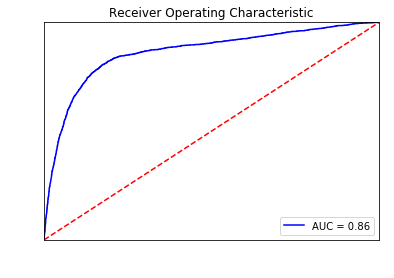

In [28]:
plot_roc_curve(pred_test, y_test)

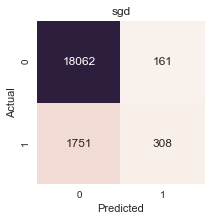

In [30]:
plot_confusion(sgd.predict(X_test), "sgd", y_test)

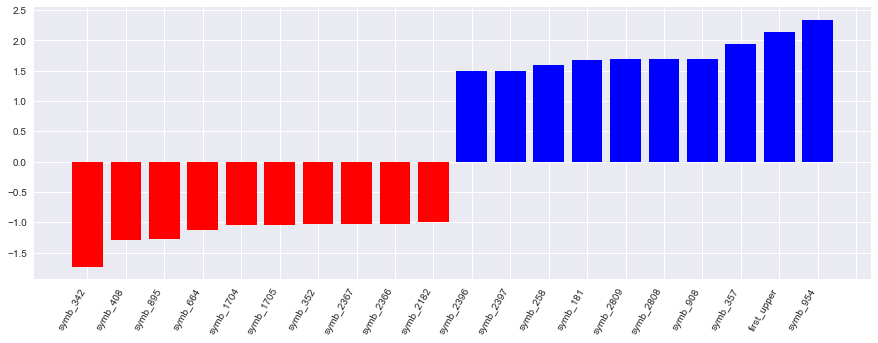

In [32]:
visualize_coefficients(sgd, X_train.columns)

In [33]:
test_preprocessed = preprocess(test, train=False)

In [34]:
prediction = sgd.predict_proba(test_preprocessed.values)

In [35]:
prediction = prediction[:, 1]

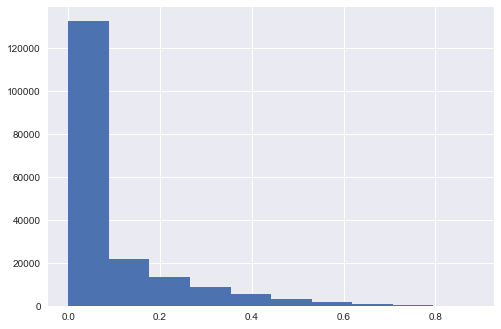

In [36]:
plt.hist(prediction);

In [37]:
prediction = pd.DataFrame(prediction)

In [38]:
prediction.reset_index(inplace=True)

In [39]:
prediction.columns = sample.columns

In [40]:
prediction.head()

,Id,Prediction
0,0,0.330127
1,1,0.302377
2,2,0.273026
3,3,0.216447
4,4,0.327113


In [41]:
prediction.to_csv('prediction.csv', index=None, index_label=None)